Importing the libraries

In [1]:
import os
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
import numpy as np

Using TensorFlow backend.
C:\Users\lucif\Anaconda3\envs\TF\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\lucif\Anaconda3\envs\TF\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\lucif\Anaconda3\envs\TF\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\lucif\Anaconda3\envs\TF\lib\site-packages\tenso

Reading movie reviews and their sentiment from txt file and saving them in a list

In [2]:
movie_reviews = []

training_labels = []

for binomial_label in ['pos','neg']:

    base_path = os.path.join("C:/Users/lucif/Documents/Jupiter_Notebook/Datasets/aclImdb/train/",binomial_label)

    for one_file in os.listdir(base_path):

        file_handle = open(os.path.join(base_path,one_file),encoding='utf8')

        movie_reviews.append(file_handle.read())

        file_handle.close()

        if binomial_label == 'pos':

            training_labels.append(1)

        else:

            training_labels.append(0)

In [3]:
len(movie_reviews)

25000

Setting the parameters for preprocessing the revies

In [4]:
maximum_important_words = 10000

In [5]:
time_steps_to_unroll = 100

Creating Tokenizer object to tokenize the reviews

In [6]:
dataset_tokenizer = Tokenizer(num_words = maximum_important_words)

In [7]:
dataset_tokenizer.fit_on_texts(movie_reviews)

In [8]:
sequences = dataset_tokenizer.texts_to_sequences(movie_reviews)

In [9]:
word_indexes = dataset_tokenizer.word_index

In [10]:
print('Unique words:',len(word_indexes))

Unique words: 88582


In [11]:
len(sequences)

25000

Padding reviews smaller than 100 tokens

In [12]:
movie_reviews_data = pad_sequences(sequences,time_steps_to_unroll)

In [13]:
movie_reviews_data

array([[5924,  482,   69, ...,   12,    9,  215],
       [ 111,   10,  255, ...,    5,  335,  405],
       [   8, 7576,    1, ...,    6,  176,  396],
       ...,
       [   1, 2817,   30, ...,   17,   96,   75],
       [ 107,    9,   29, ...,  260, 1195,  794],
       [ 344,   39,  106, ...,   11,    6, 1350]])

Splitting the Training and Validation data

In [14]:
training_labels = np.asarray(training_labels)
movie_reviews_indices = np.arange(movie_reviews_data.shape[0])
np.random.shuffle(movie_reviews_indices)
movie_reviews_data = movie_reviews_data[movie_reviews_indices]
training_labels = training_labels[movie_reviews_indices]
training_movie_reviews = movie_reviews_data[:int(0.7*len(movie_reviews_data))]
actual_training_labels = training_labels[:int(0.7*len(training_labels))]
validation_movie_reviews = movie_reviews_data[int(0.7*len(movie_reviews_data)):]
validation_labels = training_labels[int(0.7*len(training_labels)):]

Reading pretrained word embedding for embedding layer

In [15]:
embedding_indices = {}

word_embeddings_file_handle = open('C:/Users/lucif/Documents/Jupiter_Notebook/WE/glove.6B.100d.txt',encoding='utf-8')

for single_embedding in word_embeddings_file_handle:

    pair = single_embedding.split()
    
    word = pair[0]

    vector = np.asarray(pair[1:],dtype='float32')
    

    embedding_indices[word] = vector

word_embeddings_file_handle.close()

Creating word embedding matrix for maximum number of important words as declared above

In [16]:
reduced_dim = 100

word_embedding_matrix = np.zeros((maximum_important_words, reduced_dim))

for word,i in word_indexes.items():

    if i < maximum_important_words:

        word_vector = embedding_indices.get(word)

        if word_vector is not None:
    
            word_embedding_matrix[i] = word_vector

Allocating available GPU

In [17]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Creating model

In [18]:
model1 = models.Sequential()

model1.add(layers.Embedding(maximum_important_words,reduced_dim,input_length=time_steps_to_unroll,weights=[word_embedding_matrix]))

model1.add(layers.LSTM(reduced_dim))

Freezing Embedding layer as we are using pre-trained word embedding

In [19]:
model1.layers[0].trainable=False

In [20]:
model1.add(layers.Dense(units=1, activation='sigmoid'))

Compiling the model with 'adam' optimizer

In [21]:
model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [22]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,080,501
Trainable params: 80,501
Non-trainable params: 1,000,000
_________________________________________________________________


Training the model

In [23]:
history1 = model1.fit(training_movie_reviews,actual_training_labels,epochs=10,batch_size=128,validation_data=(validation_movie_reviews,validation_labels))

Train on 17500 samples, validate on 7500 samples
Epoch 1/10
17500/17500 [==============================] - 20s 1ms/step - loss: 0.5892 - acc: 0.6803 - val_loss: 0.5060 - val_acc: 0.7564
Epoch 2/10
17500/17500 [==============================] - 19s 1ms/step - loss: 0.4815 - acc: 0.7705 - val_loss: 0.4650 - val_acc: 0.7803
Epoch 3/10
17500/17500 [==============================] - 19s 1ms/step - loss: 0.4505 - acc: 0.7906 - val_loss: 0.4202 - val_acc: 0.8060
Epoch 4/10
17500/17500 [==============================] - 19s 1ms/step - loss: 0.4078 - acc: 0.8120 - val_loss: 0.4175 - val_acc: 0.8061
Epoch 5/10
17500/17500 [==============================] - 19s 1ms/step - loss: 0.3773 - acc: 0.8272 - val_loss: 0.3944 - val_acc: 0.8204
Epoch 6/10
17500/17500 [==============================] - 19s 1ms/step - loss: 0.3546 - acc: 0.8431 - val_loss: 0.3693 - val_acc: 0.8344
Epoch 7/10
17500/17500 [==============================] - 19s 1ms/step - loss: 0.3392 - acc: 0.8494 - val_loss: 0.3696 - val_acc:

Readin the testing revies from txt files and creating the list the same way we did with training reviews

In [24]:
testing_movie_reviews = []

testing_labels = []

for binomial_label in ['pos','neg']:

    base_path = os.path.join("C:/Users/lucif/Documents/Jupiter_Notebook/Datasets/aclImdb/test/",binomial_label)

    for one_file in os.listdir(base_path):

        file_handle = open(os.path.join(base_path,one_file),encoding='utf8')

        testing_movie_reviews.append(file_handle.read())

        file_handle.close()

        if binomial_label == 'pos':

            testing_labels.append(1)

        else:

            testing_labels.append(0)

Tokenizing testing reviews

In [25]:
testing_sequence=dataset_tokenizer.texts_to_sequences(testing_movie_reviews)
testing_reviews=pad_sequences(testing_sequence,time_steps_to_unroll)

In [26]:
testing_reviews.shape

(25000, 100)

Predicting the result

In [27]:
y_pred=model1.predict_classes(testing_reviews,batch_size=128)

In [28]:
y_pred.shape

(25000, 1)

Accuracy

In [29]:
np.count_nonzero(np.equal(testing_labels,list(y_pred.reshape(25000,))))*100/25000

84.844

Loss Curve

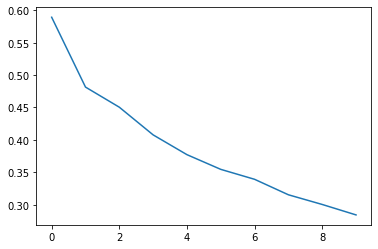

In [30]:
plt.plot(range(len(history1.history['loss'])),history1.history['loss'])